# **Redo 란?**

- 데이터파일, 컨트롤 파일에 가해지는 모든 변경사항을 Redo 에 기록.
- REDO는 오래된 데이터를 최신 데이터로 만들기 위해 존재.

**목적**

- Database Recovery
  - Redo로그는 물리적으로 디스크가 꺠지는 등의 Media Fail발생 시 데이터베이스를 복구. Media Recovery 라고도 한다.

- Cache Recovery
  - 사용자가 Update등의 작업시 버퍼캐시에는 작업이 완료되었지만 디스크 상의 파일에는 적용되지 않은 상태에서 인스턴스가 비정상 종료될때, Redo 로그를 이용하여 모든 트랜잭션을 복구하고 Undo 데이터를 이용해 비정상 종료 지점까지 복구.

- Fast Commit
  - 대량 작업의 기록을 먼저 빠르게 로그파일에 기록을하고 메모리 블록과 디스크 블록의 동기화는 나중에 일괄 수행. 이때 비정상 종료가 되더라도 Redo 로그에 먼저 기록하고 작업하므로 모두 복구가 가능.


# **Redo의 구조**

1. 데이터의 변경은 캐시에서 이루어짐.
2. 그때 REDO 로그(변경 이력 데이터)라고 불리는 로그 데이터가 생성.
3. 블록의 데이터가 이 시점(커밋되지 않은 시점)에 변경된다는 점.
4. REDO 로그를 커밋이 발생하기 전에 디스크에 기록하는 방식으로 여러 상용 DBMS(Oracle, MySQL, PostgreSQL 등)들은 지속성(D)을 구현.
5. 단, 앞에서도 설명했듯이 성능에 단점이 있으므로 커밋하는 시점에 연동해서 데이터 블록을 기록하려고 하지는 않음.



**REDO 로그의 구조**

- REDO 로그용 메모리로서 REDO 로그 버퍼가 공유 메모리에 존재.
  - REDO 로그를 디스크에 REDO 로그 파일로 기록하는 것은 LGWR이라고 불리는 프로세스가 수행.

- REDO 로그 파일은 개수가 한정(일반적으론 한 세트에 3개)되어 있으며, 크기도 제한되어 있으므로 REDO 로그를 계속 보관하고 있을 수는 없다.
- 아카이브  REDO 로그 파일이라는 오랫동안 REDO 로그를 보관해두기 위한 파일이 존재.
- REDO 로그 파일은 REDO 로그의 일시적인 보관 창고이며, 아카이브 REDO 로그 파일이 오랜 시간 보관할 수 있는 본격적인 보관 창고.
- 데이터베이스의 백업을 받으면 백업을 시작한 시점 이전에 만들어진 아카이브 REDO 로그는 필요하지 않음.

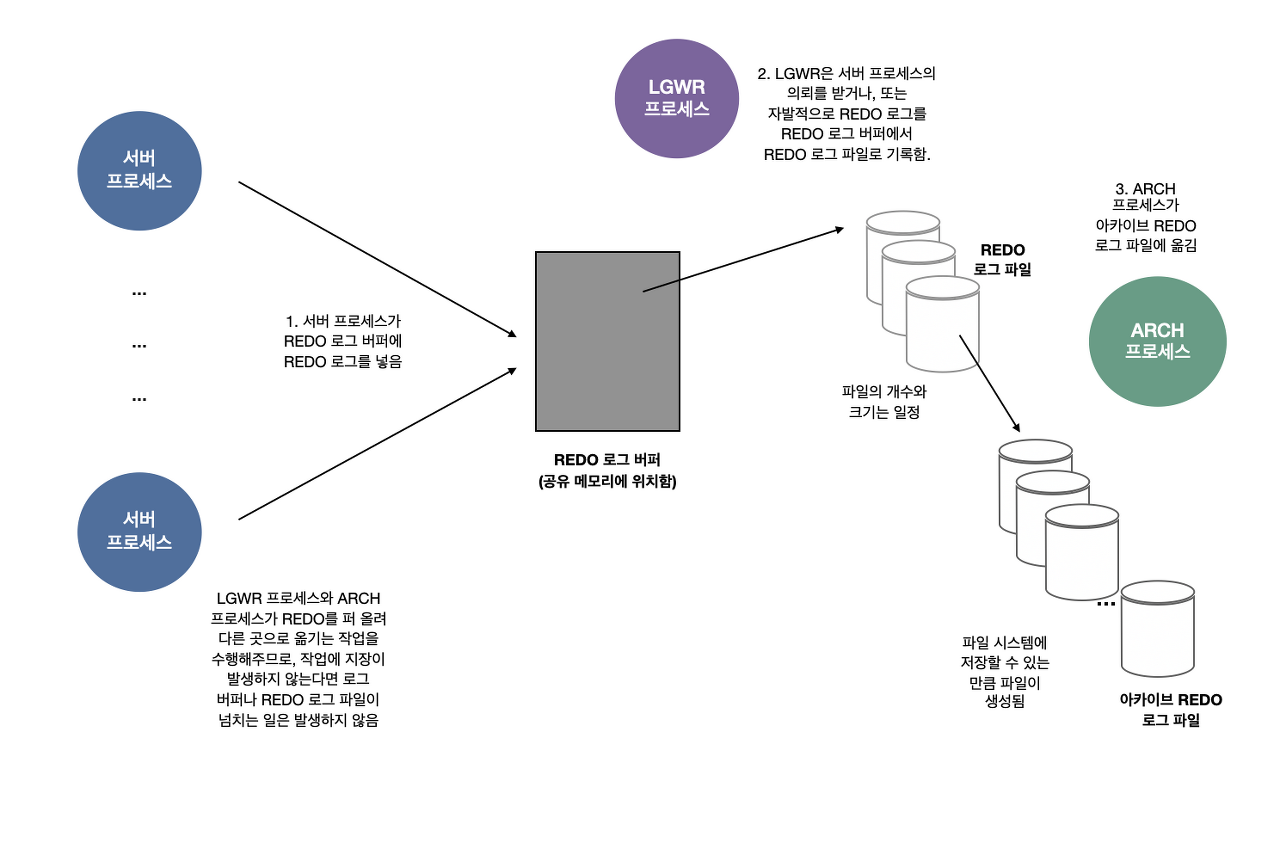

- REDO 로그 파일은 매우 중요한 파일이므로 반드시 다중화해야 한다.
  -  일반적으로 REDO 로그 그룹을 여러 개의 세트로 만들고, 그룹 안에 멤버(REDO 로그 파일)를 추가.
  - 다중화하면 '그룹이 늘어난다'고 생각할 수 있지만, 실제로는 그룹이 아닌 '멤버'가 늘어나기 때문에 예상했던 내용과 다른 형태의 다중화가 될 수 있으므로 신경을 써야 한다.

1. 서버 프로세스는 커밋했을 때 LGWR 프로세스에 REDO 로그를 기록하도록 요청.
2. 요청을 받은 LGWR 프로세스는 REDO 로그를 REDO 로그 파일에 기록.
3. 기록이 끝나면 LGWR 프로세스가 서버 프로세스에 기록이 끝났다고 통보.
4. 그 후에 서버 프로세스는 커밋이 끝난 것을 오라클 클라이언트에게 통보.


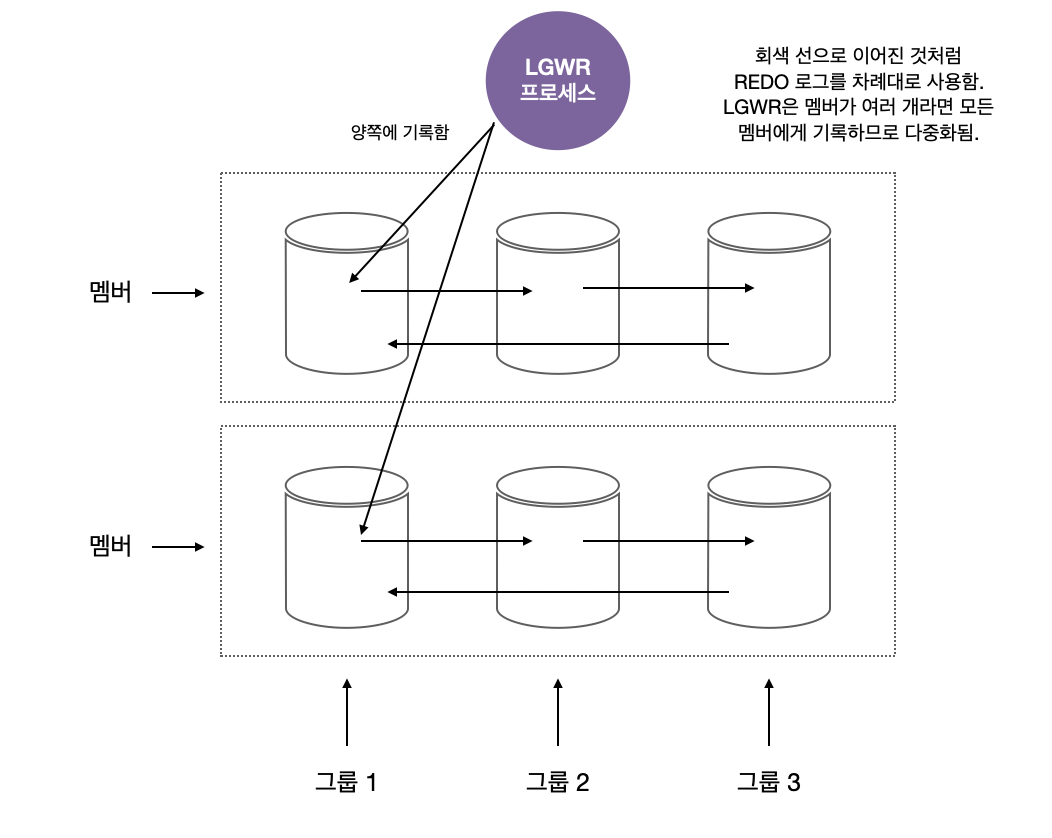

# **REDO 장점**


**병렬 처리를 가능케 하고 높은 처리량을 실현**

- 기본적으로 여러 개의 서버 프로세스는 데이터를 동시에 변경할 수 있다.(단, 같은 데이터는 제외).
- REDO 로그를 기록하는 데에서도 LGWR은 여러 서버 프로세스의 REDO 로그를 한꺼번에 기록하기 때문에 높은 처리량을 구현.



**응답 시간(response time)을 중시**
- 커밋할 때 블록을 디스크에 기록하지 않고 REDO 로그에 기록하는 것으로 빠른 커밋을 구현.



**커밋(commit)한 데이터는 지킴**
- 장비에 장애가 발생하여 DBWR이 데이터를 기록할 틈도 없었다고 가정하더라도 그 후에 REDO 로그와 데이터 파일에 남아 있는 오래된 데이터를 사용해서 데이터를 복구(롤 포워드)할 수 있다.





# **Undo 란?**

- Undo는 데이터 변경에 따른 기록을 하는 로그 파일이다.
- UNDO는 최신 데이터를 오래된 데이터로 만들기 위해 존재.
  - 읽기 일관성을 위해 UNDO를 사용.
  - 복구를 할때 사용자가 했던 작업을 그대로 다시 하지만 UNDO는 사용자가 했던 작업을 반대로 진행. 즉 사용자의 작업을 원상태로 되돌린다.


**목적**

- Transaction Rollback
  - 일반적으로 변경사항을 커밋하지않고 롤백할때 사용하는 데이터
- Transaction Recovery
  - Redo에서 비정상 종료를 복구할때 최종 커밋하지않은 변경사항도 복구. 이후 Undo 데이터로 커밋하지않은 트랜잭션을 모두 롤백.
- Read Consistency
  - 읽기 일관성에 사용된다.
  - 예를들어 사용자a의 변경사항을 커밋하지 않을때 사용자 b는 커밋되지 않은 변경사항을 볼 수 없다.

# **UNDO 구조**


- 데이터가 변경되면 UNDO 정보가 생성되며, 생성된 UNDO 정보는 세그먼트에 보관된다.
  - 세그먼트에 보관된다는 점으로 인해 UNDO 정보가 테이블스페이스들 중 어딘가에 보관된다는 사실을 알 수 있음.
- UNDO 정보가 보관되는 테이블스페이스를 UNDO 테이블스페이스라고 부름.
  - UNDO 테이블스페이스에는 여러 개의 UNDO 세그먼트가 생성.
  - 기본적으로 트랜잭션과 UNDO 세그먼트가 일대일로 대응.
- UNDO 세그먼트는 링 버퍼(ring buffer).
  - 링 버퍼는 조금 지나면 데이터가 덮어쓰이는 버퍼이지만, 커밋하지 않은 데이터는 덮어써지지 않는다.
  - 덮어쓰지 못하고 UNDO 세그먼트가 가득 차면 UNDO 세그먼트가 커진다.
- undo_retention이라는 파라미터 등으로 UNDO 정보의 유지 시간을 설정할 수 있다.
  - UNDO 정보를 커밋한 이후에도 일정 시간 유지하고 싶을 때 유용한 파라미터.





# **정리**


- REDO는 오래된 데이터를 최신 데이터로 만들기 위해 존재한다.
- UNDO는 최신 데이터를 오래된 데이터로 만들기 위해 존재한다.
- 읽기 일관성을 위해 UNDO를 사용한다.
- 장비에 장애가 발생하거나 인스턴스가 비정상 종료했을 때는 REDO와 UNDO를 사용해서 데이터를 복구하고, 커밋하지 않은 데이터의 롤백을 수행한다.


- ex: COMMIT1 > COMMIT2 > COMMIT3 일 때 COMMIT1로 돌아간다면
  - REDO는 COMMIT1의 로그를 찾아 덮어씌운다 : COMMIT2와 COMMIT3로는 돌아갈 수 없다.
  - UNDO는 COMMIT3 > COMMIT2 > COMMIT1로 순차적으로 돌아간다 : COMMIT2와 COMMIT3은 남아있다.

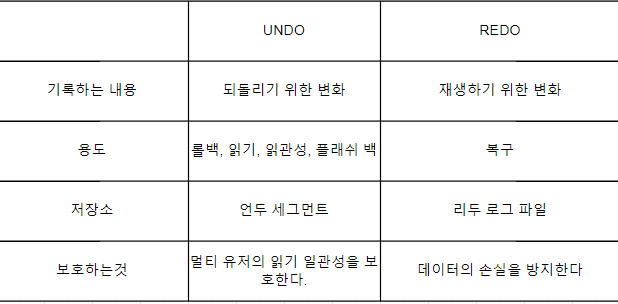